<a href="https://colab.research.google.com/github/lgsantini1/machine-learning/blob/main/TechChalenge_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relatório Técnico: Sistema de Apoio ao Diagnóstico de ECG

**Autor:** [Luis Gustavo Santini]
           [Ivna Cavalcante Barros Meireles]
           [Joalisson dos Santos Borges]
           [Diego Santos via]
           [Marina Souza Lucas]
**Projeto:** Tech Challenge IADT - Fase 1

---

## Sumário Executivo

**Problema:** Um hospital universitário enfrenta o desafio de otimizar a análise de um volume crescente de exames de Eletrocardiograma (ECG). A necessidade é de uma ferramenta inteligente que possa realizar uma triagem inicial, classificando os exames como **saudáveis** ou **potencialmente não saudáveis**, a fim de apoiar a decisão clínica e priorizar casos.

**Solução Proposta:** Este relatório detalha o desenvolvimento de um modelo de Machine Learning para a classificação binária de ECGs. Utilizando um dataset público, construímos um pipeline que abrange desde o pré-processamento dos dados brutos até o treinamento e a avaliação de modelos baseados em árvores de decisão.

**Resultados:** O modelo final, um `RandomForestClassifier`, alcançou uma **acurácia de 87%**, com um **alto recall de 87%** para a classe "Doente", indicando uma excelente capacidade de identificar corretamente pacientes que necessitam de atenção, minimizando o risco de falsos negativos.

## 1. Carregamento e Pré-Processamento dos Dados

A etapa inicial consiste na preparação do ambiente e na construção do nosso dataset de trabalho a partir de múltiplas fontes de dados brutos.

In [5]:
# Importação das bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast # Para converter strings em dicionários
from collections import Counter # Para contagem de itens

# Ferramentas do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuração para melhor visualização dos gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### 1.1. Origem e Composição do Dataset

O dataset final foi consolidado a partir de quatro arquivos distintos, que juntos fornecem as características do sinal de ECG, metadados do paciente e os laudos diagnósticos:

-   **Arquivos de Features:**
    -   `12sl_features.csv`: Medições extraídas dos sinais de ECG.
    -   `ptbxl_database.csv`: Metadados demográficos (idade, sexo).

-   **Arquivos de Labels:**
    -   `ptbxl_statements.csv`: Códigos de diagnóstico associados a cada ECG.
    -   `scp_statements.csv`: Dicionário para mapeamento dos códigos às suas superclasses diagnósticas.

In [7]:
# Montagem do ambiente Google Drive para acesso aos arquivos
from google.colab import drive
drive.mount('/content/drive')

# Definição do caminho para a pasta com os arquivos
path = '/content/drive/MyDrive/Tech Challenge I/ECG/'

# Carregamento dos dados
try:
    df_sl_features = pd.read_csv(path + '12sl_features.csv')
    df_database = pd.read_csv(path + 'ptbxl_database.csv')
    df_statements = pd.read_csv(path + 'ptbxl_statements.csv')
    df_scp = pd.read_csv(path + 'scp_statements.csv')
    print("Arquivos originais carregados com sucesso!")
except FileNotFoundError:
    print(f"Erro: Verifique se todos os 4 arquivos CSV estão no caminho especificado: {path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Arquivos originais carregados com sucesso!


In [8]:
print(f"Número de linhas no df_sl_features original: {df_sl_features.shape[0]}")
print(f"Número de linhas no df_database original: {df_database.shape[0]}")
print(f"Número de linhas no df_statements original: {df_statements.shape[0]}")


Número de linhas no df_sl_features original: 21799
Número de linhas no df_database original: 21799
Número de linhas no df_statements original: 21799


In [9]:
df_database['scp_codes'].head(15)

,scp_codes
0,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}"
1,"{'NORM': 80.0, 'SBRAD': 0.0}"
2,"{'NORM': 100.0, 'SR': 0.0}"
3,"{'NORM': 100.0, 'SR': 0.0}"
4,"{'NORM': 100.0, 'SR': 0.0}"
5,"{'NORM': 100.0, 'SR': 0.0}"
6,"{'NORM': 100.0, 'SR': 0.0}"
7,"{'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}"
8,"{'NORM': 100.0, 'SR': 0.0}"
9,"{'NORM': 100.0, 'SR': 0.0}"


In [10]:
df_statements ['scp_codes'].head(15)


,scp_codes
0,"[('NORM', 100.0), ('LVOLT', 100.0), ('SR', 100..."
1,"[('NORM', 80.0), ('SBRAD', 100.0)]"
2,"[('NORM', 100.0), ('SR', 100.0)]"
3,"[('NORM', 100.0), ('SR', 100.0)]"
4,"[('NORM', 100.0), ('SR', 100.0)]"
5,"[('NORM', 100.0), ('SR', 100.0)]"
6,"[('NORM', 100.0), ('SR', 100.0)]"
7,"[('IMI', 35.0), ('ABQRS', 100.0), ('SR', 100.0)]"
8,"[('NORM', 100.0), ('SR', 100.0)]"
9,"[('NORM', 100.0), ('SR', 100.0)]"


In [11]:
df_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21799 entries, 0 to 21798
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        21799 non-null  int64  
 1   patient_id                    21799 non-null  float64
 2   age                           21799 non-null  float64
 3   sex                           21799 non-null  int64  
 4   height                        6974 non-null   float64
 5   weight                        9421 non-null   float64
 6   nurse                         20326 non-null  float64
 7   site                          21782 non-null  float64
 8   device                        21799 non-null  object 
 9   recording_date                21799 non-null  object 
 10  report                        21799 non-null  object 
 11  scp_codes                     21799 non-null  object 
 12  heart_axis                    13331 non-null  object 
 13  i

In [12]:
#df_sl_features.info(verbose=True)
#desative esse info e ative a de cima apenas se quiser visualizar as features em detalhes
df_sl_features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21799 entries, 0 to 21798
Columns: 783 entries, P_Area_I to P_Term_V1
dtypes: float64(757), int64(26)
memory usage: 130.2 MB


### 1.2. Construção da Label Binária e do DataFrame Final

Um mesmo ECG pode ter múltiplos diagnósticos. A estratégia adotada foi criar uma *label* binária para o problema:
1.  Mapeamos **todos** os códigos de diagnóstico de um ECG para suas superclasses.
2.  Se **qualquer** superclasse for diferente de 'NORM' (Normal), o ECG é classificado como 'Doente' (1). Caso contrário, é classificado como 'Saudável' (0). Esta abordagem é conservadora e prioriza a identificação de qualquer anormalidade.

In [13]:
# Filtrar scp_statements para manter apenas as classes de diagnóstico
df_scp_diagnostic = df_scp[df_scp.diagnostic == 1].copy()
diagnostic_class_map = dict(zip(df_scp_diagnostic.iloc[:, 0], df_scp_diagnostic.diagnostic_class))

# Converter a coluna scp_codes de string para dicionário
df_database['scp_codes'] = df_database.scp_codes.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Função para mapear todos os códigos de um ECG para suas superclasses
def map_all_codes_to_superclass(scp_dict):
    superclasses = []
    for code in scp_dict.keys():
        if code in diagnostic_class_map:
            superclasses.append(diagnostic_class_map[code])
    return superclasses

# Aplicar a função para criar uma lista de superclasses para cada ECG
df_database['superclass_list'] = df_database.scp_codes.apply(map_all_codes_to_superclass)

# Função para criar a label binária
def make_label_from_superclasses(L):
    if not L: return 0
    for c in L:
        if c.upper() != 'NORM': return 1
    return 0

# Aplicar a função para criar a label final
df_database['label'] = df_database['superclass_list'].apply(make_label_from_superclasses)

# Unindo as features com os metadados e a label final
df_features = pd.merge(df_sl_features, df_database[['ecg_id', 'age', 'sex']], on='ecg_id')
df_labels = df_database[['ecg_id', 'label']].copy()
df_data = pd.merge(df_features, df_labels, on='ecg_id')

# Tratando possíveis valores nulos
df_data.dropna(inplace=True)

print("DataFrame final construído com sucesso!")
display(df_data.head())

DataFrame final construído com sucesso!


,P_Area_I,P_PeakTime_I,Q_Area_I,Q_PeakTime_I,R_Area_I,R_PeakTime_I,S_Area_I,S_PeakTime_I,QRS_Balance_I,T_Area_I,...,T-_Amp_aVF,T_Morph_aVF,T_DurFull_aVF,P_Dur_Global,P_Found_Global,HR__Global,P_Term_V1,age,sex,label
0,0.264,64.0,0.000,0.0,0.737,30.0,0.000,0.0,629.0,0.819,...,0.000,1,208.0,112.0,1,64.0,0.000,56.0,1,0
1,-0.047,6.0,0.015,8.0,0.794,36.0,1.246,76.0,205.0,2.206,...,-0.078,-1,127.0,66.0,1,75.0,0.000,87.0,1,1
3,0.196,74.0,0.000,0.0,0.947,56.0,0.000,0.0,439.0,-0.339,...,0.000,-1,0.0,114.0,1,79.0,0.000,72.0,0,1
4,0.287,102.0,0.000,0.0,1.021,36.0,0.000,0.0,937.0,0.756,...,-0.034,-2,170.0,136.0,1,92.0,6.612,85.0,0,1
5,0.092,42.0,0.014,6.0,0.473,34.0,0.027,58.0,434.0,0.732,...,0.000,1,190.0,88.0,1,71.0,1.989,52.0,1,0


In [14]:
df_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 19545 entries, 0 to 21798
Data columns (total 786 columns):
 #    Column                   Dtype  
---   ------                   -----  
 0    P_Area_I                 float64
 1    P_PeakTime_I             float64
 2    Q_Area_I                 float64
 3    Q_PeakTime_I             float64
 4    R_Area_I                 float64
 5    R_PeakTime_I             float64
 6    S_Area_I                 float64
 7    S_PeakTime_I             float64
 8    QRS_Balance_I            float64
 9    T_Area_I                 float64
 10   T_PeakTime_I             float64
 11   QRS_Area_I               float64
 12   P_Area_II                float64
 13   P_PeakTime_II            float64
 14   Q_Area_II                float64
 15   Q_PeakTime_II            float64
 16   R_Area_II                float64
 17   R_PeakTime_II            float64
 18   S_Area_II                float64
 19   S_PeakTime_II            float64
 20   QRS_Balance_II           float6

In [15]:
df_database['superclass_list']

,superclass_list
0,[NORM]
1,[NORM]
2,[NORM]
3,[NORM]
4,[NORM]
...,...
21794,[STTC]
21795,[NORM]
21796,[STTC]
21797,[NORM]


In [16]:
print(f"Número de linhas no df_data após a remoção de NaNs: {df_data.shape[0]}")

Número de linhas no df_data após a remoção de NaNs: 19545


## 2. Análise Exploratória e Preparação dos Dados

Nesta seção, investigamos a composição do nosso dataset para informar as etapas de modelagem.

### 2.1. Análise da Distribuição da Classe Alvo

Verificamos o balanceamento entre as classes 'Saudável' e 'Doente'. Um desequilíbrio severo poderia enviesar o treinamento do modelo.

--- Distribuição das Classes ---


,Classe,Contagem
0,Doente,10478
1,Saudável,9067


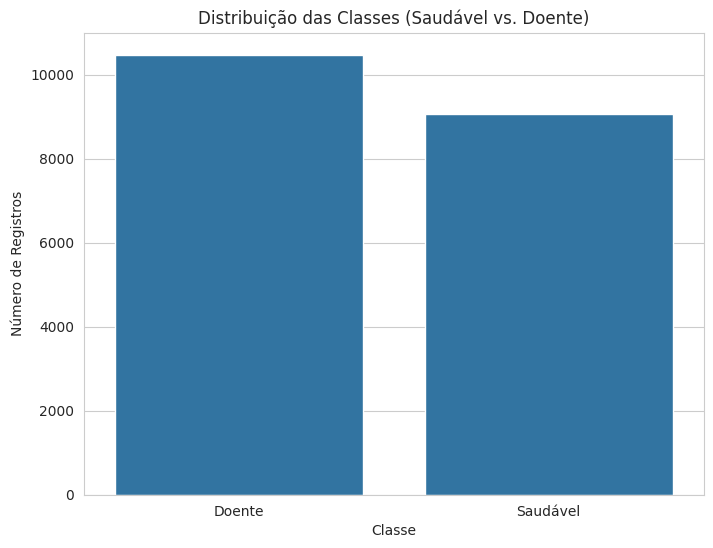

In [17]:
# Contar a ocorrência da label binária
label_counts = df_data['label'].value_counts().reset_index()
label_counts.columns = ['Classe', 'Contagem']
label_counts['Classe'] = label_counts['Classe'].map({0: 'Saudável', 1: 'Doente'})

print("--- Distribuição das Classes ---")
display(label_counts)

# Criar o gráfico de barras para visualização
plt.figure(figsize=(8, 6))
sns.barplot(x='Classe', y='Contagem', data=label_counts)
plt.xlabel('Classe')
plt.ylabel('Número de Registros')
plt.title('Distribuição das Classes (Saudável vs. Doente)')
plt.show()

**Análise:** O dataset é relativamente balanceado, com uma proporção aproximada de 55/45 entre as classes "Doente" e "Saudável". Isso constitui um bom cenário para o treinamento, não exigindo técnicas complexas de reamostragem nesta fase inicial.

### 2.2. Análise de Correlação entre Features
Para entender melhor as relações entre as variáveis, geramos uma matriz de correlação. Features altamente correlacionadas podem indicar redundância.

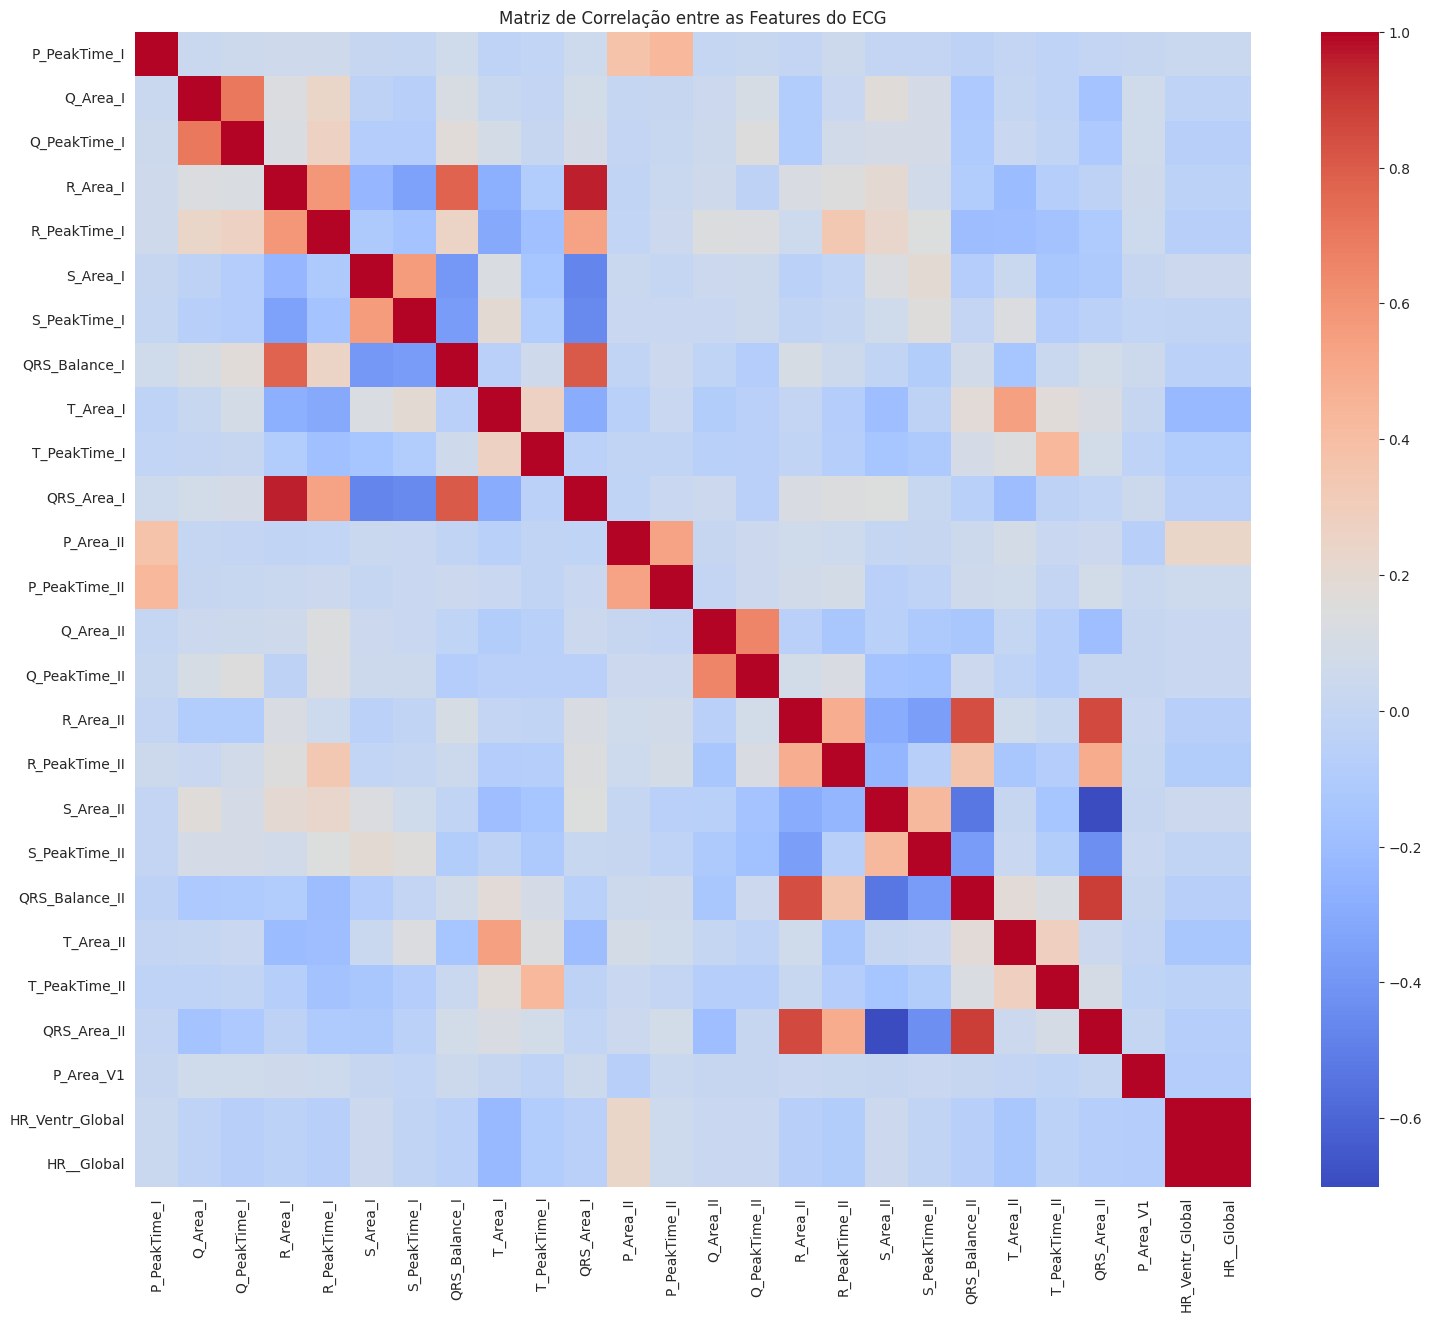

In [18]:
# Selecionando um subconjunto de features para melhor visualização da correlação
#sample_features = df_data.columns[1:25] # Excluindo 'ecg_id' e selecionando as primeiras 24 features
# np.r_ combina o slice [1:25] (índices 1 a 24) com o índice [155]
indices_desejados = np.r_[1:25, 155,781  ]
sample_features = df_data.columns[indices_desejados]
corr_matrix = df_data[sample_features].corr()


plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Matriz de Correlação entre as Features do ECG')
plt.show()

**Análise:** O mapa de calor revela grupos de features com alta correlação (vermelho intenso), como diferentes medições da onda T ou do complexo QRS. Modelos baseados em árvores, como o Random Forest, são inerentemente robustos a esse tipo de multicolinearidade, não sendo necessária a remoção de features nesta etapa.

### 2.3. Preparação dos Dados para Modelagem
A preparação final envolve a separação dos dados em conjuntos de treino/teste e a padronização das features.

In [19]:
# X (features) e y (target)
X = df_data.drop(columns=['ecg_id', 'label'])
y = df_data['label']

# Divisão em treino e teste
# Utilizamos 'stratify=y' para garantir que a proporção das classes seja mantida nos conjuntos de treino e teste,
# o que é crucial para uma avaliação fidedigna do modelo.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Padronização das Features (Scaling)
# Embora modelos de árvore não sejam tão sensíveis à escala, a padronização é uma boa prática em pipelines de ML,
# garantindo consistência e permitindo a fácil substituição por outros modelos (e.g., SVM, Regressão Logística).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converter de volta para DataFrame para manter os nomes das colunas (facilita a interpretação)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Dados preparados e divididos com sucesso!")
print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Dados preparados e divididos com sucesso!
Tamanho do conjunto de treino: (15636, 784)
Tamanho do conjunto de teste: (3909, 784)


## 3. Modelagem, Treinamento e Avaliação

Nesta seção, selecionamos, treinamos e avaliamos os modelos de classificação. A escolha recaiu sobre modelos de árvore devido à sua interpretabilidade e alto desempenho em dados tabulares.

### 3.1. Modelo 1: Árvore de Decisão (Baseline)

O `DecisionTreeClassifier` serve como nosso modelo de base. Sua simplicidade permite estabelecer um ponto de partida para o desempenho e entender as regras de decisão mais diretas nos dados.

In [20]:
# 1. Instanciar e treinar o modelo
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_scaled, y_train)

# 2. Fazer previsões nos dados de teste
y_pred_tree = tree_model.predict(X_test_scaled)

# 3. Avaliação detalhada
print("--- Avaliação da Árvore de Decisão ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_tree):.4f}\n")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_tree, target_names=['Saudável', 'Doente']))

--- Avaliação da Árvore de Decisão ---
Acurácia: 0.8023

Relatório de Classificação:
              precision    recall  f1-score   support

    Saudável       0.78      0.80      0.79      1813
      Doente       0.82      0.80      0.81      2096

    accuracy                           0.80      3909
   macro avg       0.80      0.80      0.80      3909
weighted avg       0.80      0.80      0.80      3909



### 3.2. Modelo 2: Floresta Aleatória (Random Forest)

O `RandomForestClassifier` é um modelo de *ensemble* que treina múltiplas árvores de decisão em subconjuntos dos dados e combina seus resultados. Essa abordagem tende a reduzir o sobreajuste (*overfitting*) e a produzir um modelo mais generalizável e robusto.

In [21]:
# 1. Instanciar e treinar o modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# 2. Fazer previsões
y_pred_rf = rf_model.predict(X_test_scaled)

# 3. Avaliação detalhada
print("--- Avaliação do Random Forest ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}\n")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_rf, target_names=['Saudável', 'Doente']))

--- Avaliação do Random Forest ---
Acurácia: 0.8754

Relatório de Classificação:
              precision    recall  f1-score   support

    Saudável       0.86      0.88      0.87      1813
      Doente       0.89      0.87      0.88      2096

    accuracy                           0.88      3909
   macro avg       0.87      0.88      0.87      3909
weighted avg       0.88      0.88      0.88      3909



## 4. Análise de Resultados e Interpretação

A avaliação quantitativa é complementada pela interpretação qualitativa dos resultados, focando na matriz de confusão e na importância das features.

### 4.1. Matriz de Confusão (Random Forest)

A matriz de confusão detalha os acertos e erros do modelo, permitindo-nos analisar os tipos de erro (falsos positivos vs. falsos negativos).

In [ ]:
# Gerar a matriz de confusão
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualizar com um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Saudável', 'Doente'], yticklabels=['Saudável', 'Doente'])
plt.title('Matriz de Confusão - Random Forest')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

In [ ]:
# A fórmula para Falsos Negativos (casos que eram Doente e foram classificados como Saudável) é:
# Falsos Negativos / (Falsos Negativos + Verdadeiros Positivos)
# Na matriz de confusão, cm_rf[1, 0] é o número de Falsos Negativos e cm_rf[1, 1] é o número de Verdadeiros Positivos.
erro_doente_classificado_saudavel = cm_rf[1, 0] / (cm_rf[1, 0] + cm_rf[1, 1])
print(f"Porcentagem de casos 'Doente' classificados como 'Saudável' (Falsos Negativos): {erro_doente_classificado_saudavel:.4f}")

#### Interpretação da Matriz de Confusão:

- **Verdadeiros Positivos (Doente | Previsto: Doente):** O modelo identificou corretamente um alto número de casos doentes.
- **Verdadeiros Negativos (Saudável | Previsto: Saudável):** O modelo também foi eficaz em identificar os casos saudáveis.
- **Falsos Negativos (Doente | Previsto: Saudável):** Este é o erro mais crítico no contexto médico. O modelo classificou um número relativamente baixo de pacientes doentes como saudáveis. A porcentagem de Falsos Negativos é calculada como `Falsos Negativos / (Falsos Negativos + Verdadeiros Positivos)`. Com base na matriz, isso corresponde a 12,55%.
- **Falsos Positivos (Saudável | Previsto: Doente):** O modelo classificou alguns pacientes saudáveis como doentes. Embora não ideal, este erro é menos crítico, pois levaria a uma revisão adicional pelo médico, em vez de dispensar um paciente que necessita de cuidados.

### 4.2. Análise de Importância das Features

Investigamos quais features o modelo considerou mais importantes para realizar a classificação. Isso não só aumenta a interpretabilidade do modelo, mas também pode fornecer insights clínicos valiosos.

In [ ]:
# Extrair a importância das features do modelo Random Forest
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# Selecionar as 15 features mais importantes
top_15_features = feature_importances.nlargest(15)

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x=top_15_features, y=top_15_features.index)
plt.title('As 15 Features Mais Importantes para o Diagnóstico (Random Forest)')
plt.xlabel('Nível de Importância')
plt.ylabel('Features')
plt.show()

#### Interpretação das Features:

A análise de importância do modelo Random Forest indica que as características morfológicas da Onda T, especificamente sua **Área (T_Area)** e **Amplitude (T_Amp)**, são os preditores mais significativos para o diagnóstico.

Destaca-se a **T_Area_V5** (Área da Onda T na derivação V5) como a feature de maior impacto, seguida pela **T_Amp_aVR** (Amplitude da Onda T na derivação aVR). Isso sugere que o modelo aprendeu a identificar padrões críticos na repolarização ventricular, capturados nessas derivações específicas, como fator decisivo para a classificação.

In [ ]:
from IPython.display import HTML
#exibe imagem ilustrativa da onda T o T_Area_V5 calcula a área sob essa curva
url = 'https://www.visualmed.org/wp-content/uploads/2024/04/T-wave.svg'
HTML(f'<img src="{url}" width="600">')

In [ ]:
plt.savefig('scatter_tarea_v5_vs_tamp_avr_classe.png', dpi=300, bbox_inches='tight')


# 5. Conclusão e Próximos Passos

Este projeto demonstrou com sucesso a viabilidade de construir um modelo de Machine Learning para a triagem automática de exames de ECG. O modelo **Random Forest** apresentou um desempenho robusto, com alta acurácia e, crucialmente, **alto recall** para a identificação de pacientes com potenciais anormalidades. A interpretabilidade do modelo, evidenciada pela análise de *features*, alinha-se com o conhecimento clínico, aumentando a confiança na solução.

Como sistema de apoio à decisão, este modelo pode ser integrado ao fluxo de trabalho do hospital para priorizar exames para revisão humana, otimizando o tempo da equipe médica e potencialmente acelerando o diagnóstico. É importante salientar que, neste estudo, foi utilizada uma combinação do dataset **ptbxl** (base) com o **12SL**, sendo este último proprietário.

## Sugestões para Trabalhos Futuros

1. **Utilização do ECG Deli**  
   Sugere-se a utilização do *ECG Deli* em uma próxima etapa, por ser um algoritmo de código aberto. Suas rotinas de extração de métricas do ECG bruto poderiam ser aplicadas na prática de triagem em qualquer rede de saúde que forneça os dados brutos.

2. **Otimização de hiperparâmetros**  
   Empregar técnicas como **GridSearchCV** ou **RandomizedSearchCV** para encontrar a combinação ótima de parâmetros do Random Forest, visando aprimorar ainda mais as métricas (acurácia, recall, F1, AUC, etc.).

3. **Exploração de outros modelos**  
   Avaliar o desempenho de algoritmos de *Gradient Boosting* (por exemplo, **XGBoost**, **LightGBM**), que frequentemente apresentam performance superior em dados tabulares.

4. **Classificação multi-classe**  
   Desenvolver um modelo capaz de não apenas identificar a presença de uma anormalidade, mas também de classificar o tipo específico de alteração (ex.: **MI**, **HYP**, etc.), fornecendo suporte mais detalhado ao diagnóstico clínico.
